# Imports

In [2]:
# %%
import sys
import plot_tools as pt
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import matplotlib as mpl
import numpy as np
from skimage import measure

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.spatial import ConvexHull
import scipy.interpolate as si
from matplotlib.colors import LightSource
import oommfpy.tools as ot

from pathlib import Path
import glob

In [3]:
import fidimag as fd
from fidimag.common import CuboidMesh
from fidimag.atomistic import Sim

# Simulation

Define a Fidimag simulation to load the magnetic configurations from `npy` files

In [65]:
FIELD = 100
nx, ny, nz = 30, 30, 30
dx, dy, dz = 1, 1, 1
mesh = CuboidMesh(nx=nx, ny=ny, nz=nz,
                  dx=dx, dy=dy, dz=dz,
                  x0=-nx * 0.5, y0=-ny * 0.5, z0=-nz * 0.5,
                  unit_length=1.,
                  periodicity=(True, True, False)
                  )
x, y, z = mesh.coordinates[:, 0], mesh.coordinates[:, 1], mesh.coordinates[:, 2]
xs, ys, zs = np.unique(x), np.unique(y), np.unique(z)

sim_name = 'sk_helix'
sim = Sim(mesh, name=sim_name, integrator='sundials_openmp')

sim.mu_s = 1
sim.add(fd.atomistic.Exchange(1))
sim.add(fd.atomistic.DMI(0.727, dmi_type='bulk'))
bz_min = FIELD
sim.add(fd.atomistic.Zeeman((0.0, 0.0, bz_min * 1e-3)), save_field=True)
# kc = -0.05
# if np.abs(kc) > 0.0:
#     sim.add(fd.atomistic.CubicAnisotropy(kc))

Number of threads (CVODE) = 8


In [66]:
GNEBM_PATH = Path('sims/fidimag/gnebm/D727e-3/npys/')

In [67]:
print(GNEBM_PATH / 'sk-tube_to_one-dim-mod_Bz480mT_REFINED_CI_238/')

sims/fidimag/gnebm/D727e-3/npys/sk-tube_to_one-dim-mod_Bz480mT_REFINED_CI_238


Here we select two specific saddle points from the skyrmion tube -> conical state simulations. These are before and after refinement of the GNEBM calculations. One of the saddle points have the creation of a BP by creating two misaligned chiral bobbers:

In [68]:
spins = []

for st in [f'sk-tube_to_one-dim-mod_Bz480mT_CI_303/image_000003.npy',
           f'sk-tube_to_one-dim-mod_Bz480mT_REFINED_CI_238/image_000013.npy']:
    sim.set_m(np.load(GNEBM_PATH / st))
    sp_copy = np.copy(sim.spin.reshape(-1, 3))
    spins.append(sp_copy)

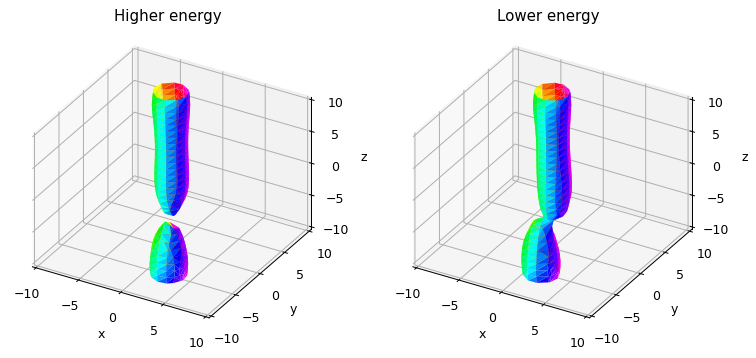

In [69]:
f = plt.figure(figsize=(10, 5))

for i, sp_idx in enumerate([0, 1]):
    
    ax = f.add_subplot(1, 2, i + 1, projection='3d', proj_type='ortho')
    # ax.set_p

    vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz)
    verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                           spacing=(1, 1, 1))
    
    verts -= 14.5
    p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                        triangles=faces,
                        # cannot control color point-wise in trisurf:  
                        color='red',
                        # cmap='RdYlBu', 
                        lw=1, vmin=-1, vmax=1
                        )
    # print(p._facecolors3d.shape)
    vol_mx = spins[sp_idx][:, 0].reshape(nx, ny, nz).T
    data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
    vol_my = spins[sp_idx][:, 1].reshape(nx, ny, nz).T
    data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
    vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz).T
    data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)
    
    tri_centres = np.mean(verts[faces], axis=1)
    # colors = mpl.cm.RdBu(data_interp(tri_centres))
    # print('tcs', tri_centres.shape)
    m_interp = np.column_stack((data_interp_x(tri_centres),
                                data_interp_y(tri_centres),
                                data_interp_z(tri_centres)))
    # print('ms', m_interp.shape)
    colors = ot.generate_colours(m_interp)
    p._facecolors2d = p._facecolors3d
    p.set_facecolors(colors)

    # ax.add_collection3d(col)

    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-10, 10])
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.set_zticks([-10, -5, 0, 5, 10])
    
f.get_axes()[0].set_title('Higher energy')
f.get_axes()[1].set_title('Lower energy')
    
plt.savefig('sk_tube_transition_Bz480_saddle-points.pdf', bbox_inches='tight')

We can plot the profile of the tubes in a slice of the sample:

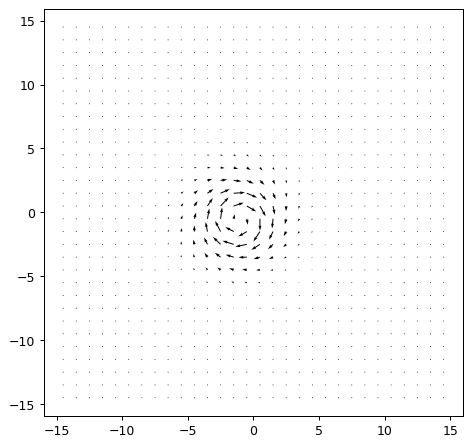

In [76]:
plt.figure(figsize=(6, 6))

ftr = z == zs[5]
spin = sim.spin.reshape(-1, 3)
plt.quiver(x[ftr], y[ftr], 
           spin[:, 0][ftr],
           spin[:, 1][ftr],
           scale=35)

Text(0.5, 0.92, 'Lower energy')

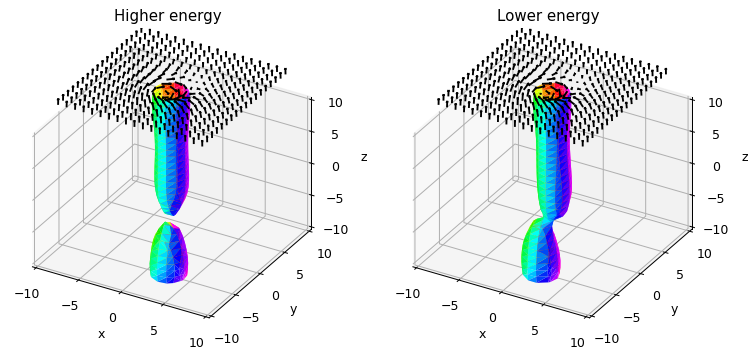

In [82]:
f = plt.figure(figsize=(10, 5))

for i, sp_idx in enumerate([0, 1]):
    
    ax = f.add_subplot(1, 2, i + 1, projection='3d', proj_type='ortho')
    # ax.set_p

    vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz)
    verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                           spacing=(1, 1, 1))
    
    verts -= 14.5
    p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                        triangles=faces,
                        # cannot control color point-wise in trisurf:  
                        color='red',
                        # cmap='RdYlBu', 
                        lw=1, vmin=-1, vmax=1
                        )
    # print(p._facecolors3d.shape)
    vol_mx = spins[sp_idx][:, 0].reshape(nx, ny, nz).T
    data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
    vol_my = spins[sp_idx][:, 1].reshape(nx, ny, nz).T
    data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
    vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz).T
    data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)
    
    tri_centres = np.mean(verts[faces], axis=1)
    # colors = mpl.cm.RdBu(data_interp(tri_centres))
    # print('tcs', tri_centres.shape)
    m_interp = np.column_stack((data_interp_x(tri_centres),
                                data_interp_y(tri_centres),
                                data_interp_z(tri_centres)))
    # print('ms', m_interp.shape)
    colors = ot.generate_colours(m_interp)
    p._facecolors2d = p._facecolors3d
    p.set_facecolors(colors)
    
    # ------------------------------------------------------------------------
    
    ftr = (z == zs[-1]) & (x < 9) & (x > -9) & (y < 9) & (y > -9)
    plt.quiver(x[ftr], y[ftr], z[ftr], 
               spins[sp_idx][:, 0][ftr],
               spins[sp_idx][:, 1][ftr],
               spins[sp_idx][:, 2][ftr], color='k'
               # scale=35
               )
    
    # ------------------------------------------------------------------------

    # ax.add_collection3d(col)

    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-10, 10])
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.set_zticks([-10, -5, 0, 5, 10])
    
f.get_axes()[0].set_title('Higher energy')
f.get_axes()[1].set_title('Lower energy')

# Colorwheel

In [5]:
from oommfpy.tools import convert_to_RGB

<ipython-input-64-7433841931e9>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axColor.pcolormesh(azimuths * np.pi / 180.0, zeniths,
<ipython-input-64-7433841931e9>:53: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0., 0.), 3, transform=axColor.transData._b,


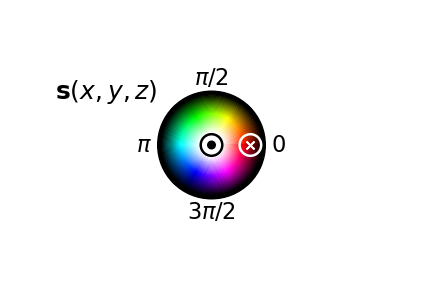

In [64]:
f, ax = plt.subplots()

box = ax.get_position()
axColor = plt.axes([0.35, 0.35,
                    0.3, 0.3], projection='polar')
azimuths = np.arange(0, 361, 1)
# For the y axis, we need an extra element so rgb has 1 less
# element along the y direction (might change in the future)
zeniths = np.arange(12, 50, 1)
dz = 38

# colours have 1 less element along y
rgb = np.ones((dz * 360, 3))
# Set the HLS hue value from 0 to 2 PI from the azimuth values
# We tile the circle 30 times: 
#   [0 ... 2PI] -> [0...2PI 0 .. 2PI ...]
rgb[:, 0] = np.tile(azimuths[:-1] * np.pi / 180, dz)
# For every circle (361 values) we increase the Light value 
# from 0 to 1, i.e. from black to white, 30 times:
#  [0 .. 1] -> [0 0 ... 0 1 1 ... 1]
greys = np.zeros(360)
greys[:340] = np.linspace(1, 0, 340)
greys[340:] = 0
rgb[:, 1] = np.repeat(greys, dz)
# Now we convert every row in HLS to RGB values
rgb = np.apply_along_axis(convert_to_RGB, 1, rgb)

axColor.pcolormesh(azimuths * np.pi / 180.0, zeniths, 
                   # only necessary as required n of args:
                   np.zeros((dz, 360)),
                   # cmap=plt.cm.hsv
                   color=rgb, shading='auto'
                   )
axColor.set_yticks([])
# axColor.set_xticks([0, np.pi * 0.5, np.pi, 1.5 * np.pi])
axColor.set_thetagrids([0, 90, 180, 270])
axColor.tick_params(axis='x', pad=0)
axColor.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$'],
                        fontsize=18
                        )

axColor.text(0., 1., r'$\mathbf{s}(x, y, z)$', 
             horizontalalignment='right',
             verticalalignment='center', transform=axColor.transAxes, 
             fontsize=20,
             # fontweight='bold'
             )

axColor.set_rlim(0, 50)
circle = plt.Circle((0., 0.), 10, transform=axColor.transData._b,
           edgecolor='k', facecolor='None', linewidth=2)
axColor.add_artist(circle)
circle = plt.Circle((0., 0.), 3, transform=axColor.transData._b, 
                   color='k', facecolor='None', linewidth=2)
axColor.add_artist(circle)
circle = plt.Circle((36., 0.), 10, transform=axColor.transData._b,
           edgecolor='w', facecolor='None', linewidth=2)
axColor.add_artist(circle)
mymarker = plt.scatter(36, 0., s=40, c='w', 
                       transform=axColor.transData._b,
                       marker='x', clip_on=False)
axColor.add_artist(mymarker)
ax.axis('off')

plt.savefig('colorwheel_full.pdf', bbox_inches='tight')

In [49]:
import matplotlib.patheffects as PathEffects

<ipython-input-62-705f07924fa4>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axColor.pcolormesh(azimuths * np.pi / 180.0, zeniths,


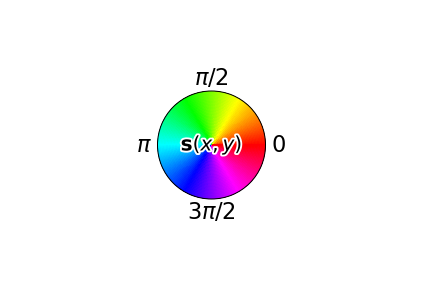

In [62]:
f, ax = plt.subplots()

box = ax.get_position()
axColor = plt.axes([0.35, 0.35,
                    0.3, 0.3], projection='polar')
azimuths = np.arange(0, 361, 1)
# For the y axis, we need an extra element so rgb has 1 less
# element along the y direction (might change in the future)
zeniths = np.arange(12, 50, 1)
dz = 38

# colours have 1 less element along y
rgb = np.ones((dz * 360, 3))
# Set the HLS hue value from 0 to 2 PI from the azimuth values
# We tile the circle "dz" times: 
#   [0 ... 2PI] -> [0...2PI 0 .. 2PI ...]
rgb[:, 0] = np.tile(azimuths[:-1] * np.pi / 180, dz)
# For every circle (361 values) we increase the Light value 
# from 0 to 1, i.e. from black to white, 30 times:
#  [0 .. 1] -> [0 0 ... 0 1 1 ... 1]
greys = np.zeros(360)
greys[:360] = np.linspace(1, 0, 360)
# greys[360:] = 1
rgb[:, 1] = 0.5
# Now we convert every row in HLS to RGB values
rgb = np.apply_along_axis(convert_to_RGB, 1, rgb)

axColor.pcolormesh(azimuths * np.pi / 180.0, zeniths, 
                   # only necessary as required n of args:
                   np.zeros((dz, 360)),
                   # cmap=plt.cm.hsv
                   color=rgb, shading='auto'
                   )
axColor.set_yticks([])
# axColor.set_xticks([0, np.pi * 0.5, np.pi, 1.5 * np.pi])
axColor.set_thetagrids([0, 90, 180, 270])
axColor.tick_params(axis='x', pad=0)
axColor.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$'],
                        fontsize=18
                        )

t = axColor.text(0.5, .5, r'$\mathbf{s}(x,y)$', 
             horizontalalignment='center',
             verticalalignment='center', transform=axColor.transAxes, 
             fontsize=16, color='k'
             # fontweight='bold'
             )
t.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

ax.axis('off')

plt.savefig('colorwheel.pdf', bbox_inches='tight')